In [ ]:
!git clone https://github.com/mahdiabdollahpour/COVID19Tweet.git

Cloning into 'COVID19Tweet'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 75 (delta 36), reused 46 (delta 14), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [ ]:
import pandas as pd
import os
import re
df=pd.read_csv("COVID19Tweet/train.tsv",sep="\t")
df.shape

(6936, 3)

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
df['Label']=pd.Categorical(df['Label'])
df['Label']=df.Label.cat.codes
df.head()

,Id,Text,Label
0,1241490299215634434,Official death toll from #covid19 in the Unite...,0
1,1245916400981381130,"Dearest Mr. President @USER 1,169 coronavirus ...",0
2,1241132432402849793,Latest Updates March 20 ⚠️5274 new cases and 3...,0
3,1236107253666607104,真把公主不当干部 BREAKING: 21 people on Grand Princess...,0
4,1239673817552879619,OKLAHOMA CITY — The State Department of Educat...,1


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
X_train=df.Text.values
Y_train=df.Label.values
Y_train=Y_train.astype('long')
# Y_train.dtype
# X_train.shape
Y_train.dtype

dtype('int64')

In [ ]:
from sklearn.model_selection import train_test_split

df=pd.read_csv("COVID19Tweet/valid.tsv",sep="\t")
df['Label']=pd.Categorical(df['Label'])
df['Label']=df.Label.cat.codes
X_val=df.Text.values
Y_val=df.Label.values
Y_val=Y_val.astype('long')



In [ ]:
X_train.shape

(6936,)

# text_preprocessing


In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# punctuation and slang pocessors

In [ ]:
def punctuation_preprocess(s):
  if ("!" or "?")in s:
    return 1
  else:
    return 0

In [ ]:
slangs=["2day","2moro","2nite","4EAE","About","ADN","AFAIC","AFAICT","AFAIK","AFAIR","AKA","AMA","ASAIC","ASAP","ATM","B4","B4N","Bae","BBL","BBT","BCNU","BD","BF","BFF","BMT","BOL","BOT","BRB","BRO","BT","BTW","CFY","CU","CUL","Cuz","CYA","DAE","DBA","DFTBA","DIKU","DM","DND","DR","DWBH","ELI5","EOM","EOS","F2F","FAQ","FB","FBF","FF","FIFY","FML","FTFY","FTL","FTW","FWB","FWIW","FYE","FYEO","FYI","GA","GAL","GF","GN","Gr8","GTR","HAND","HB","HBD","HBU","HMB","HMU","HRU","HTH","IAC","IC","ICYMI","IDC","IDK","IG","IKR","IMHO","IMMD","IMY","IRL","ISO","IU2U","J4F","JAM","JFY","JIC","JK","KK","L8","L8R","LMAO","LMBO","LMK","LOL","LTNS","LYLAS","M/F","M8","MP","MSM","MU","MYOB","NAGI","NBD","NE1","NM","NP","NSFL","NSFW","NTS","OC","OH","OIC","OMD","OMG","OMW","OT","OFC","PAW","Pls","POTD","POV",'PPL',"PTB","Q4U","QQ","RBTL","RIP","RL","ROFL","RT","RTM","SIS","SITD","SM","SMH","SMY","SNH","SOL","Some1","SRSLY","STBY","Str8","SYS","TBA","TBH","TBT","TBT","TFH","TFTI","TGIF","THX","TIA","TIL","TL;DR","TLC","TMI","TTYL","TTYS","Txt","TYVM",'U',"U4F","WEG","WKND","WOM","WOTD","Wru","WTH","WTPA","WU","WYCM","WYWH","XOXO","YGM","YNK","YOLO","YT","YW"]
def slang_preprocess(s):
  lower_slangs=[text.lower() for text in slangs]
  lists=s.split()
  lists=[x.lower() for x in lists]
  for slang in lower_slangs:
    if slang in lists:
      return 1
  return 0

In [ ]:
import numpy as np
X_train_punctuation=np.array([punctuation_preprocess(text) for text in X_train])
X_val_punctuation=np.array([punctuation_preprocess(text) for text in X_val])
X_train_slang=np.array([slang_preprocess(text) for text in X_train])
X_val_slang=np.array([slang_preprocess(text) for text in X_val])
X_val_slang

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
%%time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text

X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=True)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 24.4 s, sys: 2.86 s, total: 27.3 s
Wall time: 27.3 s


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(10, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, Y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  0.3


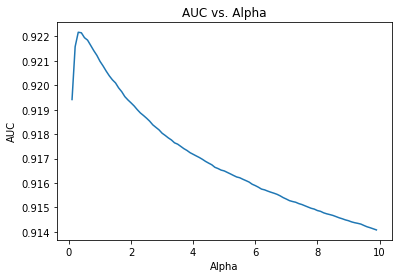

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(0.1, 10, 0.1)],
                index=np.arange(0.1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8882
Accuracy: 79.00%


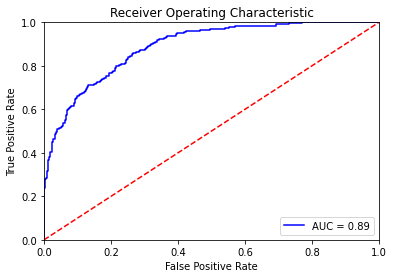

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=0.3)
nb_model.fit(X_train_tfidf, Y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, Y_val)

In [ ]:
probs

array([[0.4624834 , 0.5375166 ],
       [0.82314038, 0.17685962],
       [0.04916936, 0.95083064],
       ...,
       [0.20025057, 0.79974943],
       [0.22502338, 0.77497662],
       [0.99043306, 0.00956694]])

In [ ]:
X_val_tfidf.shape

(1000, 266854)

In [ ]:
def probs_to_class(probs):
    '''
    input probabilty of each class 
    '''
    preds = probs[:, 1]
    y_pred = np.where(preds >= 0.5, 1, 0)
    return y_pred
y_pred=probs_to_class(probs)
y_pred

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(Y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.77      0.78       472
     class 1       0.80      0.81      0.80       528

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000



# now we try huggingface


In [ ]:
import pandas as pd
import os
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
import torch
from transformers import BertTokenizer

# # Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True ,     # Return attention mask
            truncation=True
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
all_tweets = np.concatenate([X_train, X_val])
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
print(len(encoded_tweets))
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)
all_tweets.shape

Token indices sequence length is longer than the specified maximum sequence length for this model (1188 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1307 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


7936
Max length:  1610


(7936,)

In [ ]:
MAX_LEN=150
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
val_masks.dtype


Original:  Official death toll from #covid19 in the United Kingdom is now GREATER than: Germany + Poland + Switzerland + Austria + Portugal + Greece + Sweden + Finland + Norway + Ireland... COMBINED. UK: 67.5 Million (233 dead) Above group: 185 Million (230 dead) HTTPURL
Token IDs:  [101, 2078, 1473, 10484, 1121, 108, 1884, 18312, 16382, 1107, 1103, 10280, 6139, 1110, 1208, 3407, 1190, 131, 176, 14170, 1183, 116, 185, 5326, 3276, 116, 188, 15648, 23921, 116, 12686, 2050, 3464, 116, 4104, 15650, 1233, 116, 176, 8871, 2093, 116, 188, 11547, 1424, 116, 15301, 1931, 116, 4040, 2787, 116, 178, 9261, 5709, 119, 119, 119, 3490, 119, 26006, 131, 5486, 119, 126, 1550, 113, 24482, 2044, 114, 1807, 1372, 131, 16183, 1550, 113, 11866, 2044, 114, 8413, 2149, 1233, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


torch.int64

In [ ]:
Y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(Y_train)
val_labels = torch.tensor(Y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
print(train_labels.dtype)
print(val_labels.dtype)
# # print(train_data.dtype)
# # print(train_sampler.dtype)
# # print(train_dataloader.dtype)
# # print(val_data.dtype)
# # print(val_sampler.dtype)
# print(val_dataloader.dtype)

torch.int64
torch.int64


In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 67 µs, sys: 4 µs, total: 71 µs
Wall time: 76.5 µs


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            #print(b_labels)
            #print(logits)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
#         print(b_labels)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=10)
train(bert_classifier, train_dataloader, val_dataloader, epochs=10, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.699027   |     -      |     -     |   10.18  
   1    |   40    |   0.692305   |     -      |     -     |   9.50   
   1    |   60    |   0.677649   |     -      |     -     |   9.50   
   1    |   80    |   0.590603   |     -      |     -     |   9.53   
   1    |   100   |   0.597295   |     -      |     -     |   9.53   
   1    |   120   |   0.527473   |     -      |     -     |   9.52   
   1    |   140   |   0.534812   |     -      |     -     |   9.53   
   1    |   160   |   0.486553   |     -      |     -     |   9.53   
   1    |   180   |   0.443943   |     -      |     -     |   9.51   
   1    |   200   |   0.512106   |     -      |     -     |   9.54   
   1    |   216   |   0.536313   |     -      |     -     |   7.52   
----------------------------------------------------------------------

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, Y_val)

# more classical approches


##with tfidf

###decision tree

AUC: 0.7107
Accuracy: 70.80%


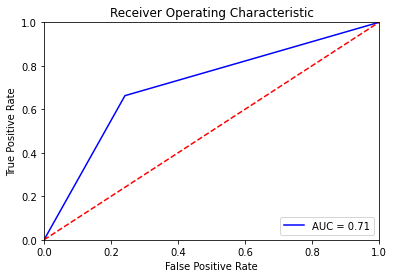

CPU times: user 7.1 s, sys: 12.5 ms, total: 7.12 s
Wall time: 7.14 s


In [ ]:
%%time
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf=clf.fit(X_train_tfidf,Y_train)
probs = clf.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, Y_val)


### svm


In [ ]:
from sklearn import svm
clf = svm.SVC()
clf=clf.fit(X_train_tfidf, Y_train)
probs=clf.predict(X_val_tfidf)
# evaluate_roc(probs, Y_val)


In [ ]:
  accuracy = accuracy_score(probs, Y_val)
  print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 80.50%


###random forest

AUC: 0.8662
Accuracy: 77.50%


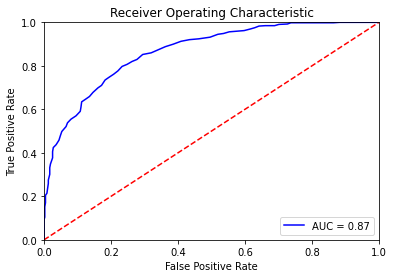

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3000, random_state=10)
clf=clf.fit(X_train_tfidf, Y_train)
probs=clf.predict_proba(X_val_tfidf)
evaluate_roc(probs, Y_val)

## word2vec


# adding meta-data

In [ ]:
!git clone https://github.com/mahdiabdollahpour/COVID19Tweet.git

Cloning into 'COVID19Tweet'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 81 (delta 40), reused 50 (delta 16), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [ ]:
import os
os.chdir('COVID19Tweet')
!git pull --verbose
os.chdir('..')

From https://github.com/mahdiabdollahpour/COVID19Tweet
 = [up to date]      master     -> origin/master
Already up to date.


In [ ]:

import pandas as pd
import os
import re
df=pd.read_csv("COVID19Tweet/train_meta.tsv",sep="\t")
df_val=pd.read_csv("COVID19Tweet/valid_meta.tsv",sep="\t")

In [ ]:
df['Label']=pd.Categorical(df['Label'])
df['Label']=df.Label.cat.codes
df["verfied"] = df["verfied"].astype(int)
df["truncated"] = df["truncated"].astype(int)
df_val['Label']=pd.Categorical(df_val['Label'])
df_val['Label']=df_val.Label.cat.codes
df_val["verfied"] = df_val["verfied"].astype(int)
df_val["truncated"] = df_val["truncated"].astype(int)
df_val.head()

,Unnamed: 0,ID,Text,verfied,retweet_count,followers_count,url_count,photo_count,truncated,listed_count,statuses_count,user_created_at,hashtag_count,friends_count,user_url,Label
0,0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0,0,648,0,0,0,12,15739,2010,2,1011,0,1
1,1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,0,0,804,1,0,0,40,52296,2010,3,3721,1,0
2,2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0,0,1162,1,0,0,6,88289,2012,1,2008,0,1
3,3,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,1,1,3517,0,1,0,76,13540,2009,4,537,1,1
4,4,1240543259299987457,Report suggested that the actual number of und...,0,0,8309,1,0,0,271,270338,2009,2,167,0,1


In [ ]:
import numpy as np
X_train=df.Text.values
Y_train=df.Label.values
Y_train=Y_train.astype('long')
X_val=df_val.Text.values
Y_val=df_val.Label.values
Y_val=Y_val.astype('long')

X_train_punctuation=np.array([punctuation_preprocess(text) for text in X_train])
X_val_punctuation=np.array([punctuation_preprocess(text) for text in X_val])
X_train_slang=np.array([slang_preprocess(text) for text in X_train])
X_val_slang=np.array([slang_preprocess(text) for text in X_val])


In [ ]:
%%time
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=False,
                         smooth_idf=True)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 24.6 s, sys: 3.14 s, total: 27.8 s
Wall time: 27.8 s


In [ ]:
X_train_tfidf.shape

(4717, 139037)

In [ ]:
X_val_tfidf.shape

(893, 139037)

In [ ]:
import math
df['slang'] = X_train_slang
df['punctuation'] = X_train_punctuation

df['len'] = [len(sen.split(' ')) for sen in X_train_preprocessed] 
df['r_over_f'] = df['retweet_count'] / df['followers_count']
df['user_created_at'] =  df['user_created_at'].apply(lambda x: 2020-x)
df['followers_count'] =  df['followers_count'].apply(lambda x: math.log(x+1))
df['friends_count'] =  df['friends_count'].apply(lambda x: math.log(x+1))
df['statuses_count'] =  df['statuses_count'].apply(lambda x: math.log(x+1))
cols = ['slang' ,'punctuation', "verfied", 'r_over_f',"followers_count","url_count","photo_count","len","listed_count",	"statuses_count","user_created_at","hashtag_count","friends_count",	"user_url"]
# cols_to_normal = ['r_over_f',"followers_count","url_count","photo_count",]
meta_data = df.loc[:, cols ]
# meta_data=(meta_data-meta_data.min())/(meta_data.max()-meta_data.min())
meta_data = (meta_data-meta_data.mean())/meta_data.std()

df_val['slang'] = X_val_slang
df_val['punctuation'] = X_val_punctuation
df_val['len'] = [len(sen.split(' ')) for sen in X_val_preprocessed] 
df_val['r_over_f'] = df_val['retweet_count'] / df_val['followers_count']
df_val['user_created_at'] =  df_val['user_created_at'].apply(lambda x: 2020-x)
df_val['followers_count'] =  df_val['followers_count'].apply(lambda x:  math.log(x+1))
df_val['friends_count'] =  df_val['friends_count'].apply(lambda x: math.log(x+1))
df_val['statuses_count'] =  df_val['statuses_count'].apply(lambda x: math.log(x+1))
meta_data_val = df_val.loc[:,  cols]
# meta_data_val=(meta_data_val-meta_data_val.min())/(meta_data_val.max()-meta_data_val.min())
meta_data_val = (meta_data_val-meta_data_val.mean())/meta_data_val.std()
meta_data.head()
# print(np.sum(meta_data_val['video_count']))

,slang,punctuation,verfied,r_over_f,followers_count,url_count,photo_count,len,listed_count,statuses_count,user_created_at,hashtag_count,friends_count,user_url
0,-0.292143,-0.27868,-0.505439,1.056080,-1.048704,0.902647,-0.599081,0.583650,-0.151477,-0.029648,0.332699,-0.132138,-0.377610,-1.215897
1,-0.292143,3.58759,-0.505439,-0.117677,0.646618,-0.921598,-0.599081,0.229951,-0.153384,-0.577436,-1.150330,-0.132138,1.473971,-1.215897
2,-0.292143,-0.27868,-0.505439,-0.112393,0.319239,-0.921598,-0.599081,1.291048,-0.145120,-0.456387,-2.040147,-0.717390,-4.260173,-1.215897
3,-0.292143,-0.27868,-0.505439,-0.089405,0.104134,2.726892,1.668869,0.583650,-0.142259,-0.378638,-1.446936,-0.717390,0.920662,-1.215897
4,-0.292143,-0.27868,-0.505439,-0.030958,-0.800922,0.902647,-0.599081,0.112051,-0.136855,-0.099953,0.332699,-0.717390,-1.212626,0.822264


In [ ]:
metadata = meta_data.to_numpy()
meta_data_val = meta_data_val.to_numpy()
print(np.shape(metadata))


(4717, 14)


## svm just tfidf

In [ ]:
from sklearn.metrics import classification_report
metadata = np.nan_to_num(metadata)
meta_data_val = np.nan_to_num(meta_data_val)
X_train_tfidf_meta=np.concatenate(X_train_tfidf,metadata)
X_val_tfidf_meta=concatenate([X_val_tfidf,meta_data_val])
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, auc
clf = svm.SVC()
clf=clf.fit(X_train_tfidf_meta, Y_train)
probs=clf.predict(X_val_tfidf_meta)
print(classification_report(Y_val, probs, target_names=["class 0","class 1"]))

TypeError: ignored

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove*.zip

--2020-08-21 20:38:14--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-08-21 20:38:14--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-08-21 20:38:15--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

KeyboardInterrupt: ignored

In [ ]:
import numpy as np

def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel
  
glove = loadGloveModel('glove.twitter.27B.200d.txt')


Loading Glove Model
400000  words loaded!


In [ ]:
weights = dict(zip(tf_idf.get_feature_names(), tf_idf.idf_))

In [ ]:
X_train_preprocessed[0]

'official death toll covid19 united kingdom greater germany poland switzerland austria portugal greece sweden finland norway ireland combined uk 67 5 million 233 dead group 185 million 230 dead httpurl'

In [ ]:
X_train_tfidf[0]

<1x181958 sparse matrix of type '<class 'numpy.float64'>'
	with 82 stored elements in Compressed Sparse Row format>

In [ ]:
# tfidf weighted glove
inverse = tf_idf.inverse_transform(X_train_tfidf)
data_train = np.zeros(shape=(len(X_train),100),dtype=np.float)
for i in range(len(X_train)):
    word_list = inverse[i]
    for word in word_list:
      if len(word.split(' ')) == 1 and word.lower() in glove :
          data_train[i,:]+= weights[word] * glove[word.lower()]
print(data_train[:3,:])

inverse_val = tf_idf.inverse_transform(X_val_tfidf)
data_val = np.zeros(shape=(len(X_val),100),dtype=np.float)
for i in range(len(X_val)):
    word_list = inverse_val[i]
    for word in word_list:
      if len(word.split(' ')) == 1 and word.lower() in glove :
          data_val[i,:]+= weights[word] * glove[word.lower()]
print(data_val[:3,:])

In [ ]:
# Without meta data
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_curve, auc
clf = svm.SVC()
clf=clf.fit(data_train, Y_train)
probs=clf.predict(data_val)
accuracy = accuracy_score(probs, Y_val)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 82.98%


In [ ]:
# tfidf weighted glove adding meta data
word_embedding_size = 100
inverse = tf_idf.inverse_transform(X_train_tfidf)
data_train = np.zeros(shape=(len(X_train),word_embedding_size+np.shape(metadata)[1]),dtype=np.float)
for i in range(len(X_train)):
    word_list = inverse[i]
    for word in word_list:
      if len(word.split(' ')) == 1 and word.lower() in glove :
          data_train[i,:word_embedding_size]+= weights[word] * glove[word.lower()]
    data_train[i,word_embedding_size:] = metadata[i]
print(data_train[:2,:])
inverse = tf_idf.inverse_transform(X_val_tfidf)
data_val = np.zeros(shape=(len(X_val),word_embedding_size+np.shape(metadata)[1]),dtype=np.float)
for i in range(len(X_val)):
    word_list = inverse[i]
    for word in word_list:
      if len(word.split(' ')) == 1 and word.lower() in glove :
          data_val[i,:word_embedding_size]+= weights[word] * glove[word.lower()]
    data_val[i,word_embedding_size:] = metadata[i]
print(data_val[:2,:])

In [ ]:
!pip install transformers

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from COVID19Tweet import NER
ners_train = np.zeros(shape=(len(X_train),4))
for i in range(len(X_train)):
  ners_train[i,:] = NER.get_hotvector_ner(X_train_preprocessed[i][:512])
ners_train = ners_train / np.sqrt(np.sum(ners_train**2))

print(ners_train[:10,:])

In [ ]:
clf = svm.SVC()
clf=clf.fit(data_train, Y_train)
probs=clf.predict(data_val)
accuracy = accuracy_score(probs, Y_val)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 83.13%


In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128, 2), random_state=1,max_iter=500)
clf.fit(data_train, Y_train)
probs =clf.predict(data_val)
accuracy = accuracy_score(probs, Y_val)
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 81.79%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(word_embedding_size), dtype="float32")
meta_inputs = tf.keras.Input(shape=(np.shape(metadata)[1]), dtype="float32")
x = layers.Dense(128, activation="relu")(inputs)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(50, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
t = layers.Dense(2, activation="relu")(meta_inputs)
# t = layers.Dropout(0.5)(t)
concatted = tf.keras.layers.Concatenate()([x, t])
y = layers.Dense(10, activation="relu")(concatted)
y = layers.Dropout(0.5)(y)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(y)
model = tf.keras.Model([inputs,meta_inputs], predictions)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x=[data_train[:,:100],data_train[:,100:]],y=Y_train, validation_split=0.1, epochs=40)



In [ ]:
probs = model.predict([data_val[:,:100],data_val[:,100:]])
def fun(a):
  if a>0.5:
    return 1
  else:
    return 0 
probs = np.apply_along_axis(fun,1,probs)
print(np.shape(probs))
# print(probs)
accuracy = accuracy_score(probs, Y_val)
print(f'Accuracy: {accuracy*100:.2f}%')

NameError: ignored